In [30]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import scipy.stats as stats
import re
import seaborn as sns
import os

In [31]:
def get_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else float('inf')

def get_exp(s):
    return re.sub(r'_\d+', '', s)  # remove trailing "_number" to get experiment name

In [32]:
input_dir = "Output"
excel_mode = True

In [33]:
animals = {}
for file in os.listdir(input_dir):
        name = os.path.join(input_dir, file)
        number = int(re.findall(r'\d+', file)[0][-2:])  # Finds all numbers, then takes last two digits
        animals[number] = pd.read_excel(name) if excel_mode else pd.read_csv(name)
print(f"Found {len(animals)} animal(s).")

Found 6 animal(s).


In [40]:
animals_df = []
animals_df_unsorted = []

animals_df = pd.concat(animals, names=['animal_id']) 


animals_df['experiment'] = animals_df['experiment'].str.replace(r'^.*?_', '', regex=True) # Remove recording name from experiment name



# Add helper columns
animals_df['has_number'] = animals_df['experiment'].str.contains(r'\d+')
animals_df['experiment_type'] = animals_df['experiment'].apply(get_exp)
animals_df['experiment_number'] = animals_df['experiment'].apply(get_number)

animals_df_unsorted = animals_df

# Sort by animal_id, then by if it has a number, then experiment type, then experiment number
animals_df = animals_df.sort_values(['animal_id', 'has_number', 'experiment_type', 'experiment_number'])

# Drop helper columns
animals_df = animals_df.drop(columns=['has_number', 'experiment_type', 'experiment_number'])

animals_df = animals_df.reset_index(level='animal_id').reset_index(drop=True)  # Flatten the index

# Drop helper columns
animals_df_unsorted = animals_df_unsorted.drop(columns=['has_number', 'experiment_type', 'experiment_number'])

animals_df_unsorted = animals_df_unsorted.reset_index(level='animal_id').reset_index(drop=True)  # Flatten the index

In [41]:
print(animals_df)

     animal_id      experiment  reactionTime  peakTime  difference  \
0            1     ASR_control         16.00     30.00        14.0   
1            1       gap_depth         16.50     30.00        13.5   
2            1   tone_in_noise         17.00     30.00        13.0   
3            1  gap_duration_4         15.60     30.00        14.4   
4            1  gap_duration_8         17.20     28.80        11.6   
..         ...             ...           ...       ...         ...   
103         15   offset_PPI_14         20.80     30.80        10.0   
104         15   offset_PPI_16         17.00     30.00        13.0   
105         15   offset_PPI_18         24.67     30.67         6.0   
106         15   offset_PPI_20         24.00     30.80         6.8   
107         15   offset_PPI_50         20.80     30.00         9.2   

     strength (RMS)  
0             40.00  
1             39.25  
2             35.75  
3             39.80  
4             32.60  
..              ...  
103  

In [46]:
print(animals_df_unsorted[['animal_id', 'experiment']].head(10))

   animal_id       experiment
0          1   gap_duration_8
1          1    offset_PPI_50
2          1    tone_in_noise
3          1    offset_PPI_10
4          1  gap_duration_10
5          1  gap_duration_20
6          1     offset_PPI_6
7          1   gap_duration_4
8          1    offset_PPI_16
9          1    offset_PPI_18


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_reaction_times(df):
    """
    Plots boxplots comparing each animal's reaction times across experiments.
    Each animal's reaction time is represented by a dot.
    
    Parameters:
    df (pd.DataFrame): DataFrame with columns ['animal_id', 'experiment', 'reactionTime']
    """
    # Check if required columns exist
    required_cols = {'animal_id', 'experiment', 'reactionTime'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")
    
    # Set up the plot
    plt.figure(figsize=(12, 6))

    # Create a list of unique experiments
    experiments = df['experiment'].unique()

    # Create a list of animal_ids for each experiment
    animal_ids = df['animal_id'].unique()

    # Prepare a color map based on animal_id
    color_map = plt.cm.get_cmap("tab20", len(animal_ids))

    # Plot boxplots per experiment
    positions = np.arange(len(experiments))  # X positions for boxplots
    boxplot_data = [df[df['experiment'] == exp]['reactionTime'].values for exp in experiments]
    
    # Create the boxplot without notches
    plt.boxplot(boxplot_data, positions=positions, widths=0.6, patch_artist=True, 
                boxprops=dict(facecolor='skyblue', color='blue', alpha=0.5), 
                whiskerprops=dict(color='blue', linewidth=2, alpha=0.5), 
                capprops=dict(color='blue', linewidth=2, alpha=0.5))

    # Overlay the dots for each animal
    for i, exp in enumerate(experiments):
        exp_data = df[df['experiment'] == exp]
        for j, animal in enumerate(animal_ids):
            # Get the reaction time for the specific animal in this experiment
            animal_data = exp_data[exp_data['animal_id'] == animal]
            # Plot each animal's reaction time as a dot
            plt.scatter([i] * len(animal_data), animal_data['reactionTime'], 
                        label=animal if i == 0 else "", 
                        color=color_map(j), zorder=5, s=70, edgecolors="black", alpha=0.8)

    # Customize the plot
    plt.xticks(positions, experiments)  # Set x-ticks to be the experiments
    plt.xticks(rotation=45)
    plt.title("Reaction Times Across Experiments")
    plt.xlabel("Experiment")
    plt.ylabel("Reaction Time (ms)")
    
    # Add legend for animal IDs
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicates from legend
    plt.legend(by_label.values(), by_label.keys(), title="Animal ID", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

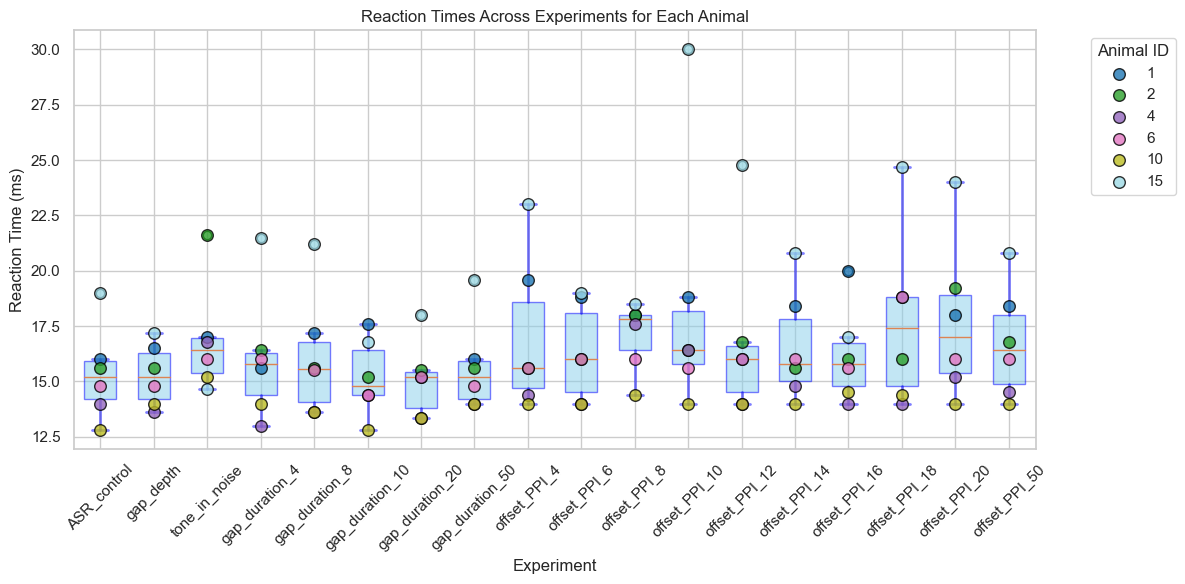

In [74]:
plot_reaction_times(animals_df)

In [ ]:
def plot_animal(animal_id):
    animal_data = animals_df[animals_df['animal_id'] == animal_id]
    plt.figure(figsize=(10, 5))
    plt.bar(animal_data['experiment'], animal_data['reactionTime'])
    
    plt.title(f'Reaction Time by Experiment (Animal {animal_id})')
    plt.xlabel('Experiment')
    plt.ylabel('Reaction Time (ms)')

    plt.xticks(rotation=45)  
    plt.tight_layout()
    plt.grid(True)
    plt.show()

<class 'pandas.core.frame.DataFrame'>


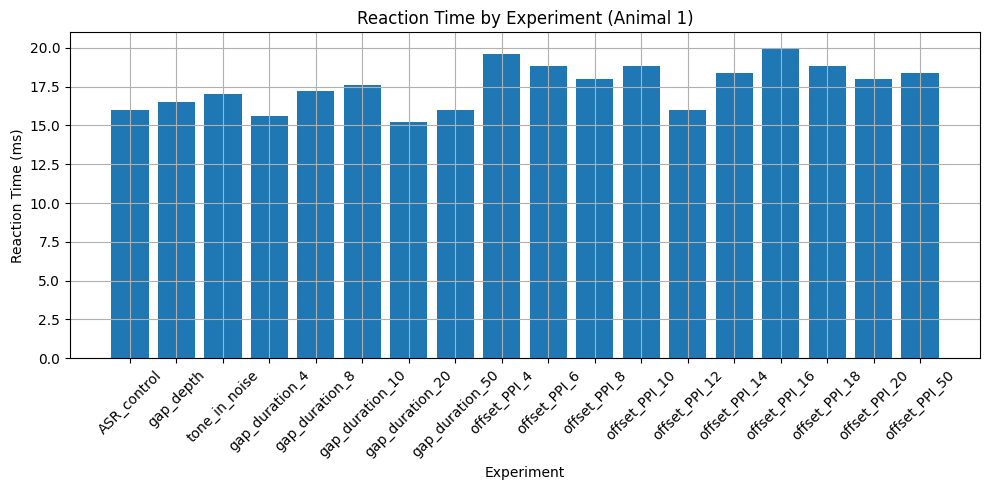

<class 'pandas.core.frame.DataFrame'>


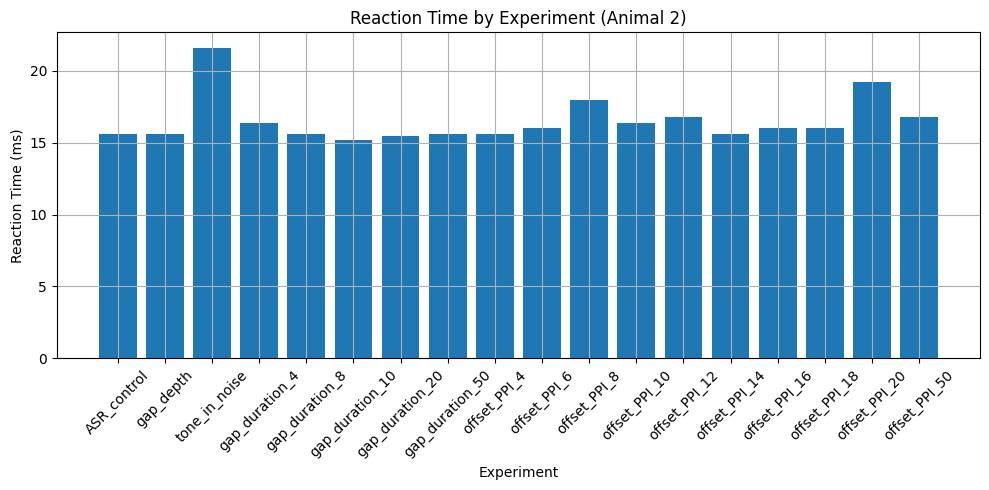

<class 'pandas.core.frame.DataFrame'>


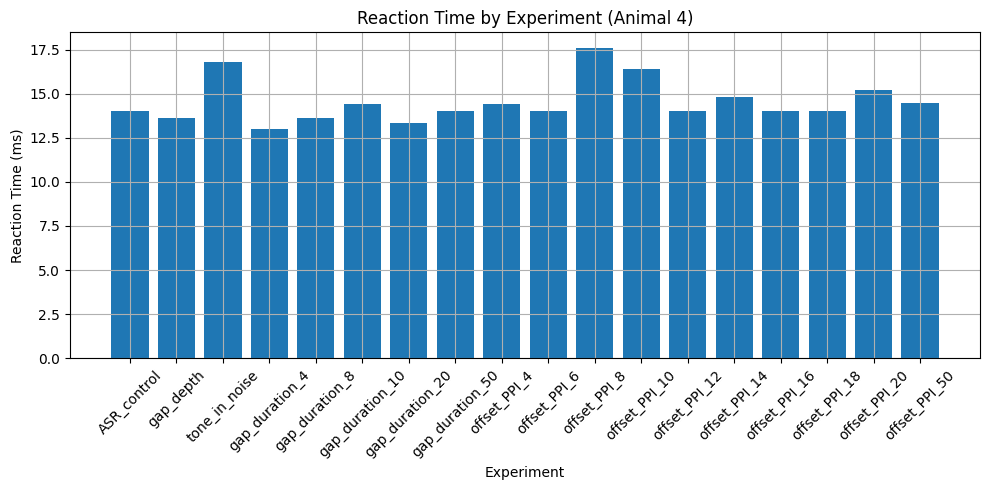

<class 'pandas.core.frame.DataFrame'>


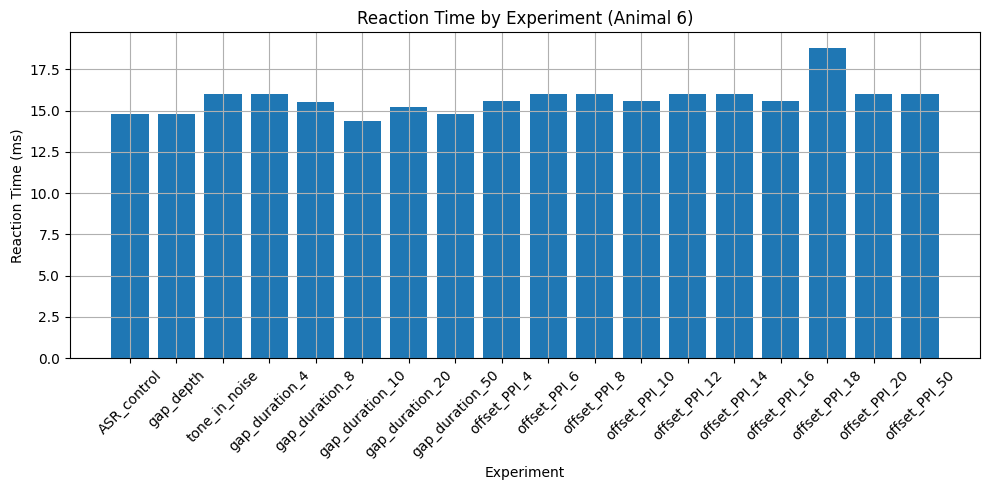

<class 'pandas.core.frame.DataFrame'>


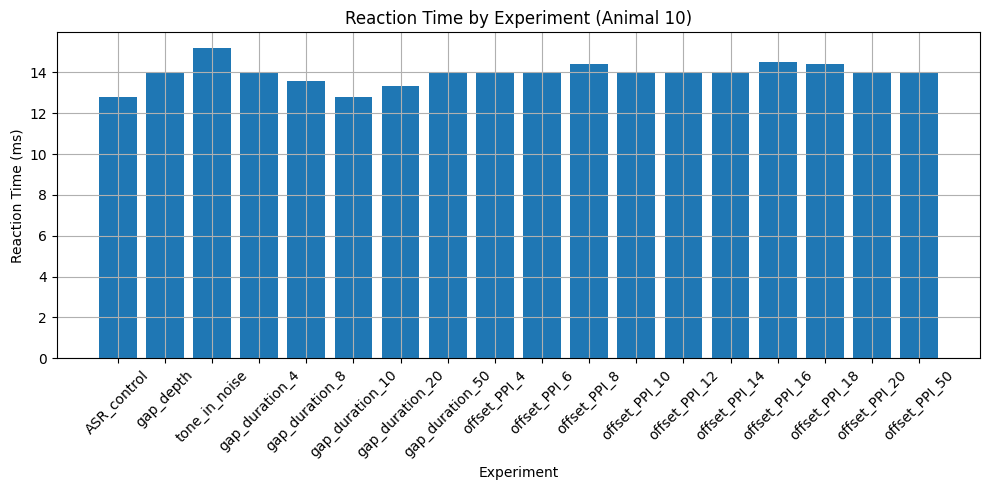

<class 'pandas.core.frame.DataFrame'>


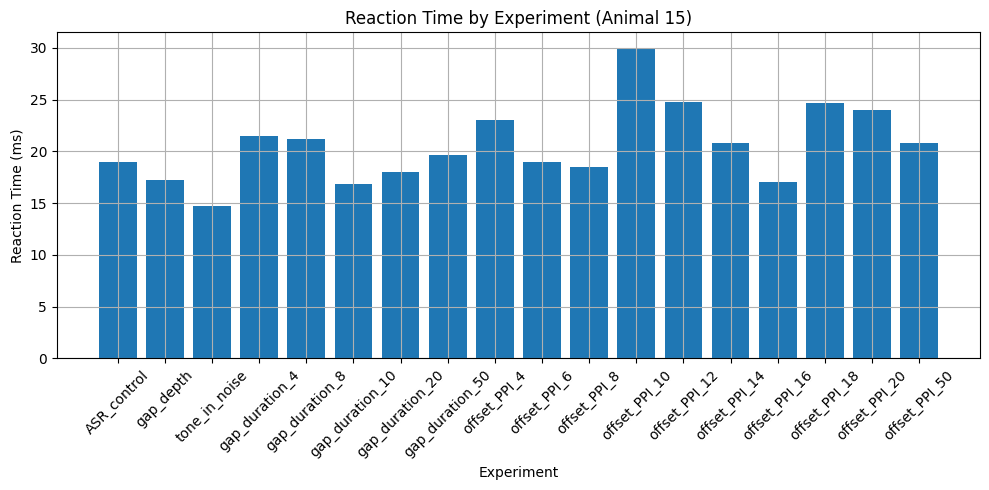

In [48]:
plot_animal(1)
plot_animal(2)
plot_animal(4)
plot_animal(6)
plot_animal(10)
plot_animal(15)